In [18]:
#IMPORTS

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import requests
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, List, Tuple, Sequence
from sklearn.preprocessing import MinMaxScaler

In [2]:
#GETTING CURRENCY RATES

def currency_converter():

    APIkey = "j4YVbY4DsPe2bRdqchwWzvccCljEhg2EhlPyfrEN"
    url = f"https://api.freecurrencyapi.com/v1/latest?apikey={APIkey}"
    response = requests.get(url).json()
    df = pd.DataFrame(response['data'], index=[0])
    return df

currency_converter()

,AUD,BGN,BRL,CAD,CHF,CNY,CZK,DKK,EUR,GBP,...,PHP,PLN,RON,RUB,SEK,SGD,THB,TRY,USD,ZAR
0,1.486615,1.860944,5.205585,1.365184,0.940397,6.973786,23.115648,7.074998,0.951231,0.818907,...,55.328432,4.464668,4.679419,63.501493,10.38175,1.355291,34.91045,18.641488,1,17.167812


In [3]:
#GETTING FEAR GRID VALUES

def fgindex() -> pd.DataFrame:
    """returns a dataframe of fear and greed index with columns:
    [value],[value_classification],[timestamp],[time_until_update] """

    url = 'https://api.alternative.me/fng/'
    params = {'limit':100000,'date_format':'world'}
    response = requests.get(url,params).json()
    fg = pd.DataFrame(response['data'])
    return fg

fgindex()

,value,value_classification,timestamp,time_until_update
0,25,Extreme Fear,08-12-2022,-1670425430
1,29,Fear,07-12-2022,NaN
2,25,Extreme Fear,06-12-2022,NaN
3,26,Fear,05-12-2022,NaN
4,26,Fear,04-12-2022,NaN
...,...,...,...,...
1764,11,Extreme Fear,05-02-2018,NaN
1765,24,Extreme Fear,04-02-2018,NaN
1766,40,Fear,03-02-2018,NaN
1767,15,Extreme Fear,02-02-2018,NaN


In [4]:
from Historic_Crypto import HistoricalData

In [5]:
#GETTING CLOSING PRICES OF CRYPTO CURRENCY

crypto = 'BTC'

def prices(crypto)-> pd.DataFrame:

    today = datetime.datetime.today().strftime('%Y-%m-%d')
    crypto_df = HistoricalData(f'{crypto}-USD',86400,'2018-01-31-00-00',f"{today}-00-00",verbose = False).retrieve_data()
    return crypto_df

prices(crypto)

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


,low,high,open,close,volume
time,,,,,
2018-02-01,8400.00,10166.25,10099.99,9014.23,38171.970034
2018-02-02,7540.00,9090.08,9014.22,8787.52,52039.268077
2018-02-03,8115.48,9499.00,8787.52,9240.00,23700.985090
2018-02-04,7859.00,9350.00,9227.80,8167.91,24062.181957
2018-02-05,6425.75,8349.16,8167.90,6905.19,59578.698221
...,...,...,...,...,...
2022-12-04,16882.86,17199.99,16889.17,17108.90,16961.108288
2022-12-05,16865.22,17424.59,17108.90,16966.05,33618.451090
2022-12-06,16904.04,17111.35,16966.05,17089.05,26693.610117


In [10]:
import datetime
def data_cleaning(crypto = 'BTC'):
    '''The function returns a dataframe containing:
    price: the historical crypto price
    index: the Grid/fear index value
    '''
    #cleaning the price data

    BTC_USD = prices(crypto)
    BTC_USD= BTC_USD['close']

    #cleaning the sentiment data
    sentiment_data = fgindex()
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['value'] = sentiment_data['value'].astype('float')
    fg= pd.DataFrame(sentiment_data[['value', 'timestamp']])
    fg.set_index('timestamp', inplace=True)


    #merging the price and sentiment data
    df = fg.join(BTC_USD)

    #cleaning the merged dataframe
    df.dropna(inplace=True)
    df.rename(columns = {'close': 'price', 'value': 'index'}, inplace = True)

    return df

df = data_cleaning()

Provisional Start: 2018-01-31T00:00:00
Provisional End: 2018-11-27T00:00:00
Provisional Start: 2018-11-27T00:00:00
Provisional End: 2019-09-23T00:00:00
Provisional Start: 2019-09-23T00:00:00
Provisional End: 2020-07-19T00:00:00
Provisional Start: 2020-07-19T00:00:00
Provisional End: 2021-05-15T00:00:00
Provisional Start: 2021-05-15T00:00:00
Provisional End: 2022-03-11T00:00:00
Provisional Start: 2022-03-11T00:00:00
Provisional End: 2023-01-05T00:00:00


In [11]:
df = df.tail(-1)
df.sort_index(ascending= True, inplace = True)

In [12]:
#########Monica's solution################

def window_data(cleaned_data,window=20,horizon=1):
    """returns two arrays:
    X : Array of lists. Each list contains n_window observations of features.
    y: Array of lists. Each list contains the price of obs n_window + 1
    """
    df = cleaned_data
    cols_to_find =['index','price']
    feature_column = [df.columns.get_loc(col) for col in cols_to_find] #CHANGE
    target_column = df.columns.get_loc('price')
    X = []
    y = []

    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window),feature_column]
        target = df.iloc[(i + window+ horizon), target_column]
        X.append(features)
        y.append(target)

    return np.array(X), np.array(y).reshape(-1, 1)

X, y = window_data(df)

X.shape


def folds(X,y,window=20):
    """ returns four arrays:
    X_train : array of lists with the 70% of the observed feature values
    X_test : array of lists with the 30% of the observed feature values
    y_train : array of lists with the 70% of the observed target values
    y_test : array of lists with the 30% of the observed target values
    """
    split = int(.7 * len(X))
    X_train = X[:split - 1]
    X_test = X[split:]

    # y split
    y_train = y[:split - 1]
    y_test = y[split:]

    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=folds(X,y)

X_train.shape,X_test.shape,y_train.shape,y_test.shape


def scaling(X_train,X_test,y_train,y_test):
    """ returns four arrays:
    X_train_scaled : array of lists with the 70% of the observed feature values scaled,
    X_test_scaled : array of lists with the 30% of the observed feature values scaled,
    y_train_scaled : array of lists with the 70% of the observed target values scaled,
    y_test_scaled : array of lists with the 30% of the observed target values scaled.
    """

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    nsamples, nx, ny = X_train.shape
    X_train = X_train.reshape((nsamples,nx*ny))
    
    nsamples, nx, ny = X_test.shape
    X_test = X_test.reshape((nsamples,nx*ny))

    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled, scaler_y


X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled, scaler_y= scaling(X_train,X_test,y_train,y_test)

X_train_scaled.shape,X_test_scaled.shape,y_train_scaled.shape,y_test_scaled.shape

X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 20, 2))

X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 20, 2))


In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Normalization

#Defining the best parameters
#best_epoch = 100
#best_window_size = 20
#best_learning_rate = 0.0001
#best_activation = 'relu'


def init_model_final(X_train, y_train):
    
    # $CHALLENGIFY_BEGIN    
    
    #normalizer = Normalization() # Instantiate a "normalizer" layer
    #normalizer.adapt(X_train, y_train) # "Fit" it on the train set
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    #model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.2))

    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='relu'))
    
    ##2.0 Defining the optimizer
    adam = optimizers.Adam(learning_rate = 0.0001)
    model.compile(loss = 'mse',
                  optimizer = adam,
                  metrics = ['mae'])

    
    return model
    # $CHALLENGIFY_END

In [14]:
import tensorflow as tf
from typing import Dict, List, Tuple, Sequence
def fit_model_final(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = 10,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train_scaled,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 100,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [15]:
# 1 - Initialising the RNN model
# ====================================

model_final = init_model_final(X_train, y_train_scaled)
#model.summary()

# 2 - Training
# ====================================
model_final, history = fit_model_final(model_final)

Epoch 1/100


2022-12-08 16:07:55.170690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


53/53 [==============================] - 5s 34ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0715 - val_mae: 0.1981
Epoch 2/100
53/53 [==============================] - 1s 14ms/step - loss: 7.3097e-04 - mae: 0.0215 - val_loss: 0.0634 - val_mae: 0.1873
Epoch 3/100
53/53 [==============================] - 1s 12ms/step - loss: 6.7142e-04 - mae: 0.0206 - val_loss: 0.0527 - val_mae: 0.1702
Epoch 4/100
53/53 [==============================] - 1s 12ms/step - loss: 5.9724e-04 - mae: 0.0193 - val_loss: 0.0436 - val_mae: 0.1544
Epoch 5/100
53/53 [==============================] - 1s 18ms/step - loss: 4.9894e-04 - mae: 0.0175 - val_loss: 0.0349 - val_mae: 0.1372
Epoch 6/100
53/53 [==============================] - 1s 17ms/step - loss: 4.3530e-04 - mae: 0.0165 - val_loss: 0.0276 - val_mae: 0.1214
Epoch 7/100
53/53 [==============================] - 1s 18ms/step - loss: 3.7742e-04 - mae: 0.0153 - val_loss: 0.0215 - val_mae: 0.1063
Epoch 8/100
53/53 [==============================] - 1s 18ms/ste

In [16]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
               
    return ax

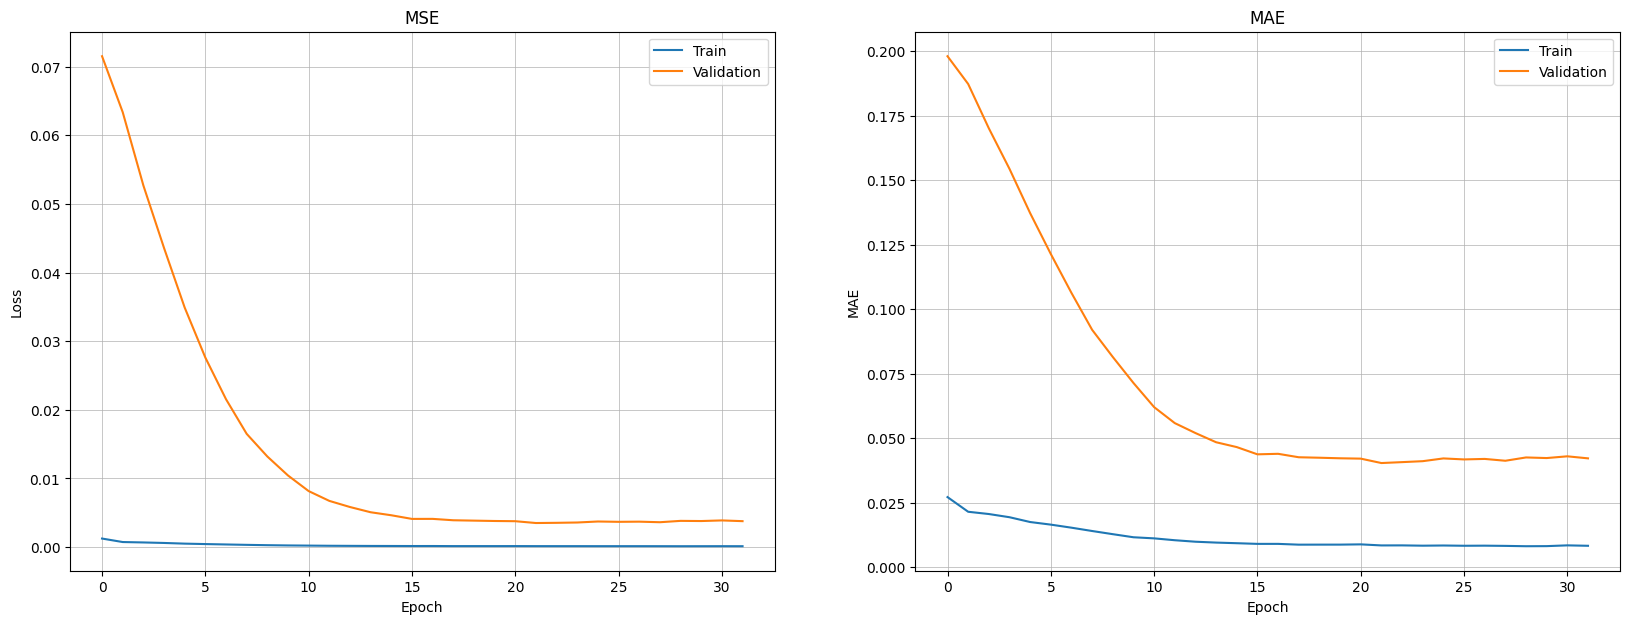

In [19]:
plot_history(history);
plt.show()

In [20]:
predicted = model_final.predict(X_test)
unscaled_pred = scaler_y.inverse_transform(predicted)

17/17 [==============================] - 0s 5ms/step


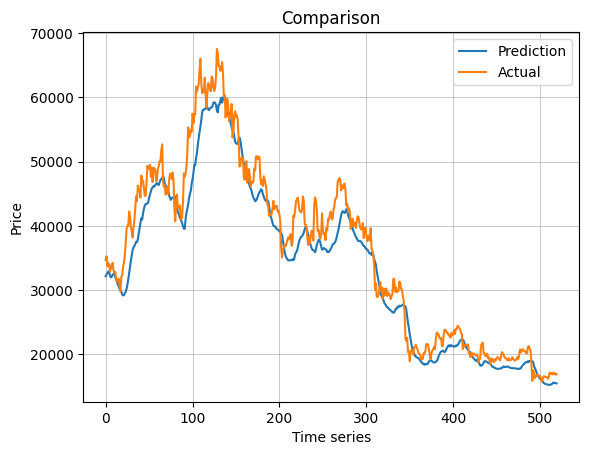

In [21]:
def plot_comparison(y_pred, y_test):
    
    #fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- y_pred --- 
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.title('Comparison')
    plt.ylabel('Price')
    plt.xlabel('Time series')
    plt.legend(['Prediction', 'Actual'], loc='best')
    plt.grid(axis="x",linewidth=0.5)
    plt.grid(axis="y",linewidth=0.5)
    

               
    return plt
plot_comparison(unscaled_pred, y_test);
plt.show()

In [31]:
def plot_loss_mae(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=0.2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)
    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])
    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)
    plt.show()

In [26]:
def init_model2(X_train, y_train, activation):
    
    # $CHALLENGIFY_BEGIN    
    
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=True, recurrent_dropout = 0.2))
    #model.add(layers.LSTM(units=64, return_sequences=True, recurrent_dropout = 0.2))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation=activation))


    
    return model
    # $CHALLENGIFY_END

In [27]:
def compile_model2(model, optimizer_name):
    # $CHALLENGIFY_BEGIN
    model.compile(loss = 'mse',
                  optimizer = optimizer_name,
                  metrics = ['mae'])
    return model

17/17 [==============================] - 0s 5ms/step - loss: 0.0110 - mae: 0.0861
MAE with learning rate 0.0001 --> 0.0861


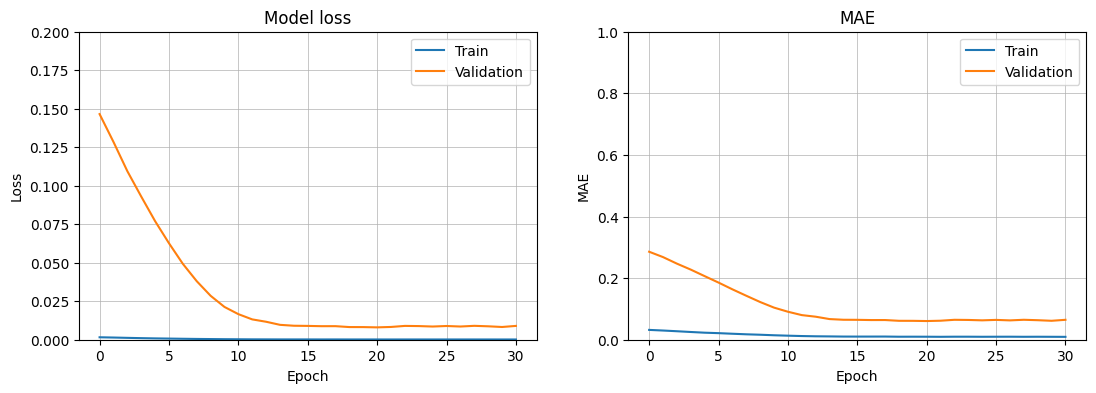

17/17 [==============================] - 0s 4ms/step - loss: 0.3479 - mae: 0.5444
MAE with learning rate 0.001 --> 0.5444


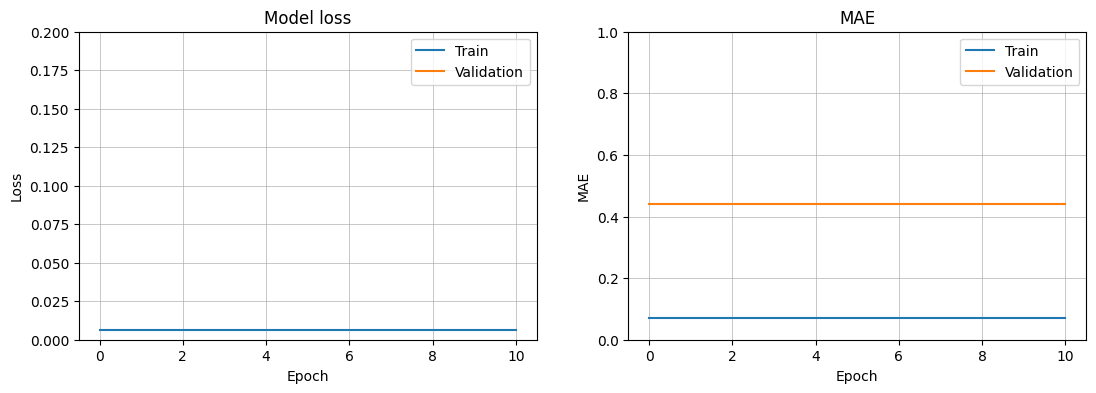

17/17 [==============================] - 0s 5ms/step - loss: 0.1368 - mae: 0.3280
MAE with learning rate 0.01 --> 0.3280


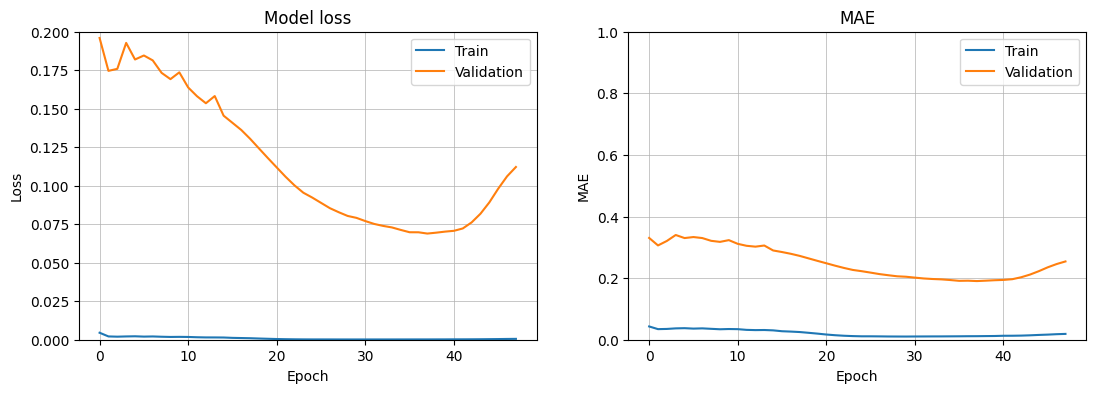

17/17 [==============================] - 0s 5ms/step - loss: 0.3479 - mae: 0.5444
MAE with learning rate 0.1 --> 0.5444


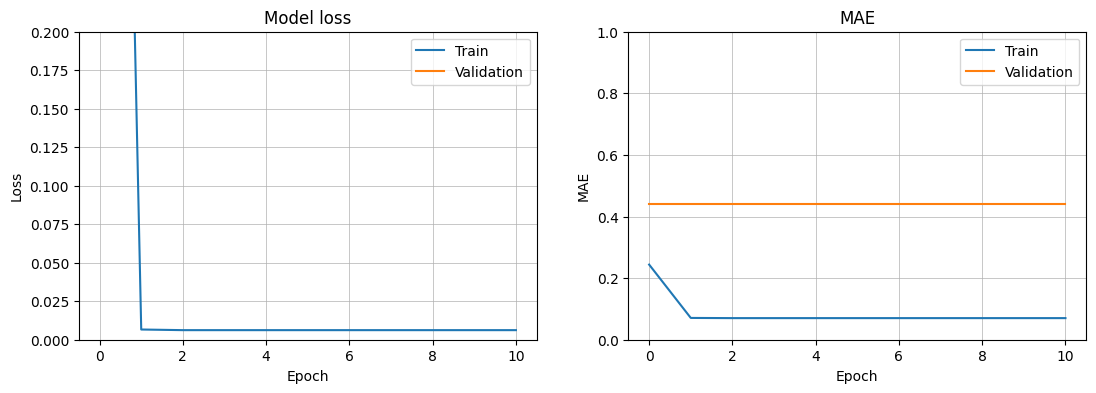

17/17 [==============================] - 0s 5ms/step - loss: 0.3479 - mae: 0.5444
MAE with learning rate 1 --> 0.5444


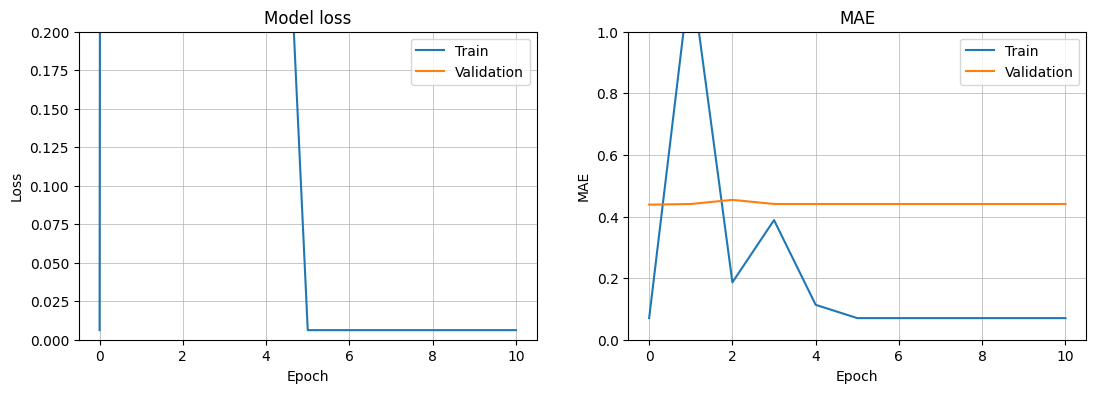

17/17 [==============================] - 0s 5ms/step - loss: 0.3479 - mae: 0.5444
MAE with learning rate 2 --> 0.5444


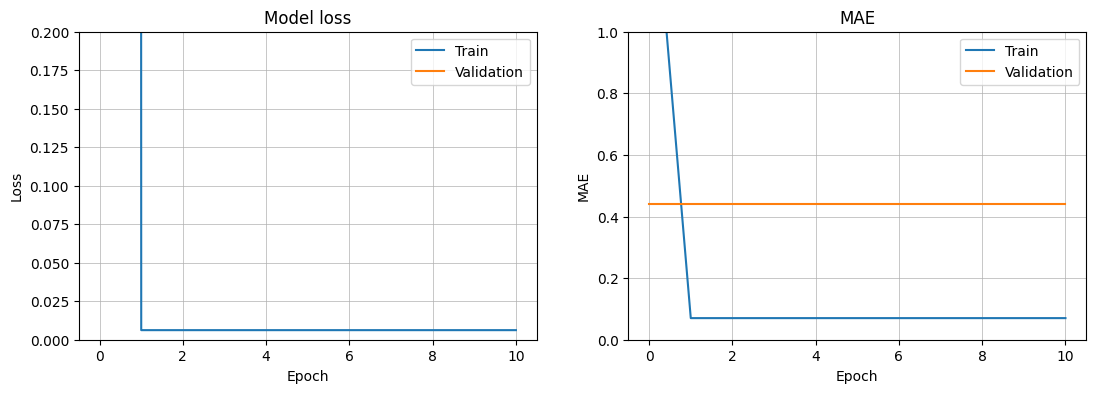

In [32]:
#adding the second feature
feature_1_column = 0
feature_2_column = 1
target_column = 1
window_size = 20
best_activation = 'relu'
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []

for learning_rate in learning_rates:
    # $CHALLENGIFY_BEGIN
    #getting the fresh data

    
    split = int(.7 * len(X))
    X_train = X_train
    X_test = X_test

    # y split
    y_train = y_train_scaled
    y_test = y_test_scaled

    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = optimizers.Adam(learning_rate = learning_rate)
    # 2. Initializing the model
    model = init_model2(X_train, y_train, best_activation)
    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model2(model, adam)
    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(X_train,
                        y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size=16,
                        epochs = 100,
                        callbacks = [es],
                        verbose = 0)
    # 5. Plot the history and evaluate the model
    res = model.evaluate(X_test, y_test)[1]
    results.append(res)
    print(f'MAE with learning rate {learning_rate} --> {res:.4f}')
    plot_loss_mae(history)